### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed May 14 04:16:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [3]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OBEE4ABTRkFaMw51pNpg")
project = rf.workspace("capstone-v0wnd").project("acne-khbou")
version = project.version(2)
dataset = version.download("yolov11")



mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [4]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [5]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 149MB/s]
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/Acne-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [6]:
!ls {HOME}/runs/detect/train/

args.yaml			 PR_curve.png	     train_batch281.jpg
confusion_matrix_normalized.png  R_curve.png	     train_batch282.jpg
confusion_matrix.png		 results.csv	     train_batch2.jpg
F1_curve.png			 results.png	     val_batch0_labels.jpg
labels_correlogram.jpg		 train_batch0.jpg    val_batch0_pred.jpg
labels.jpg			 train_batch1.jpg    weights
P_curve.png			 train_batch280.jpg


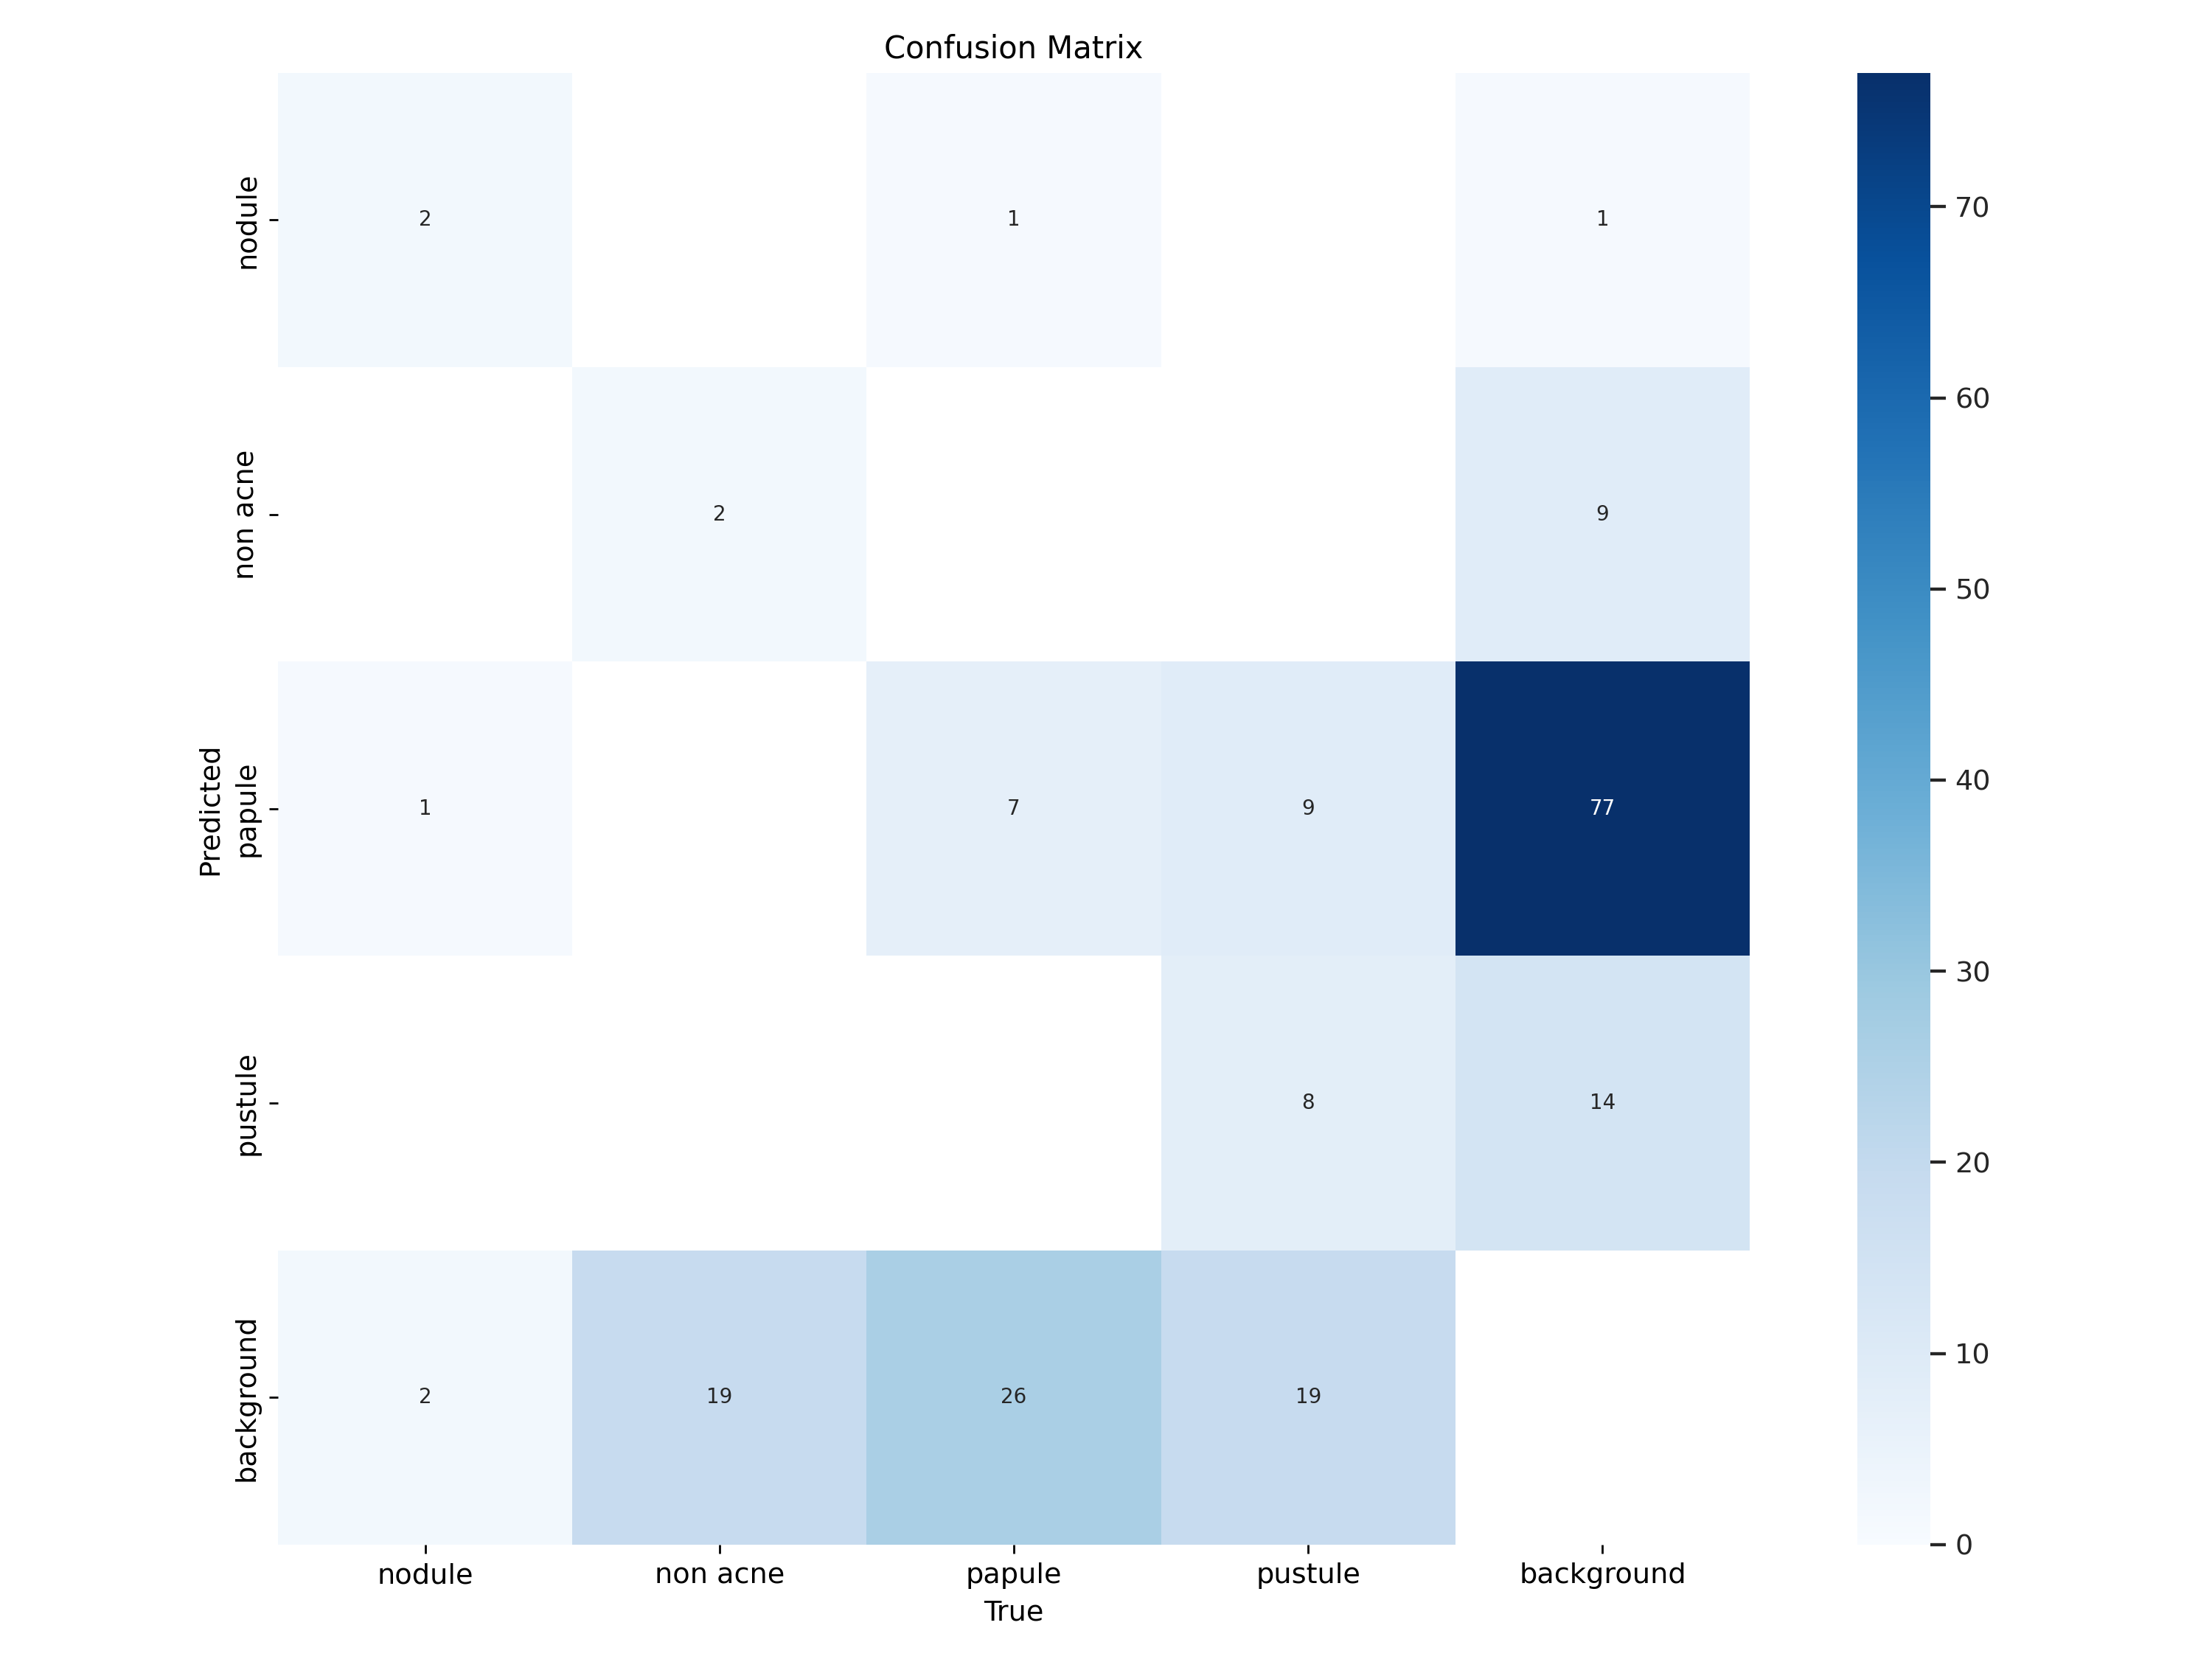

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

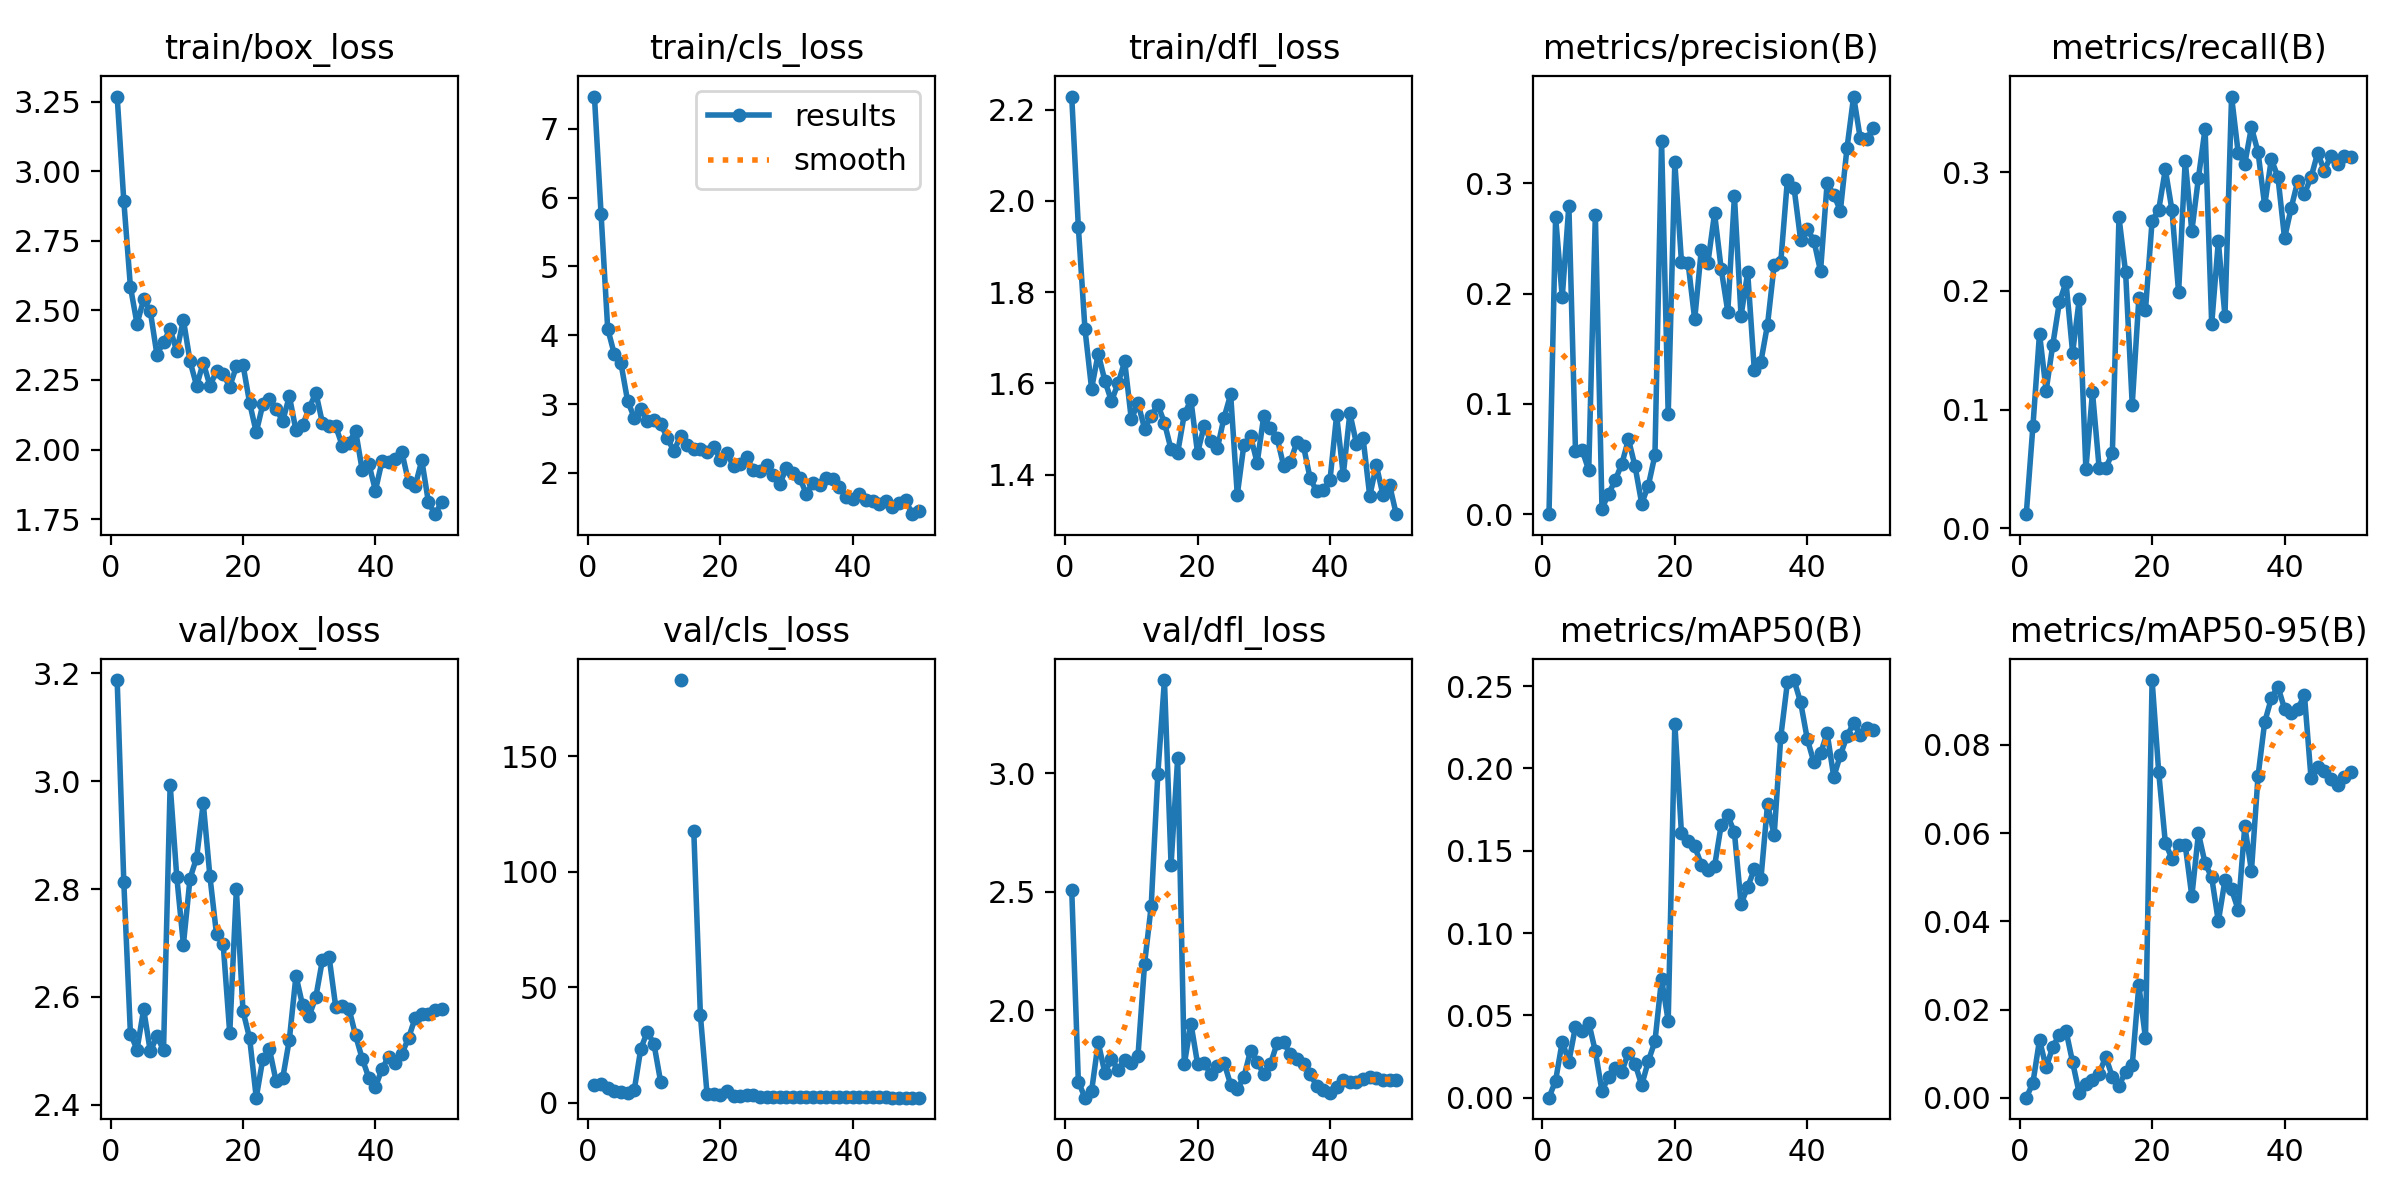

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

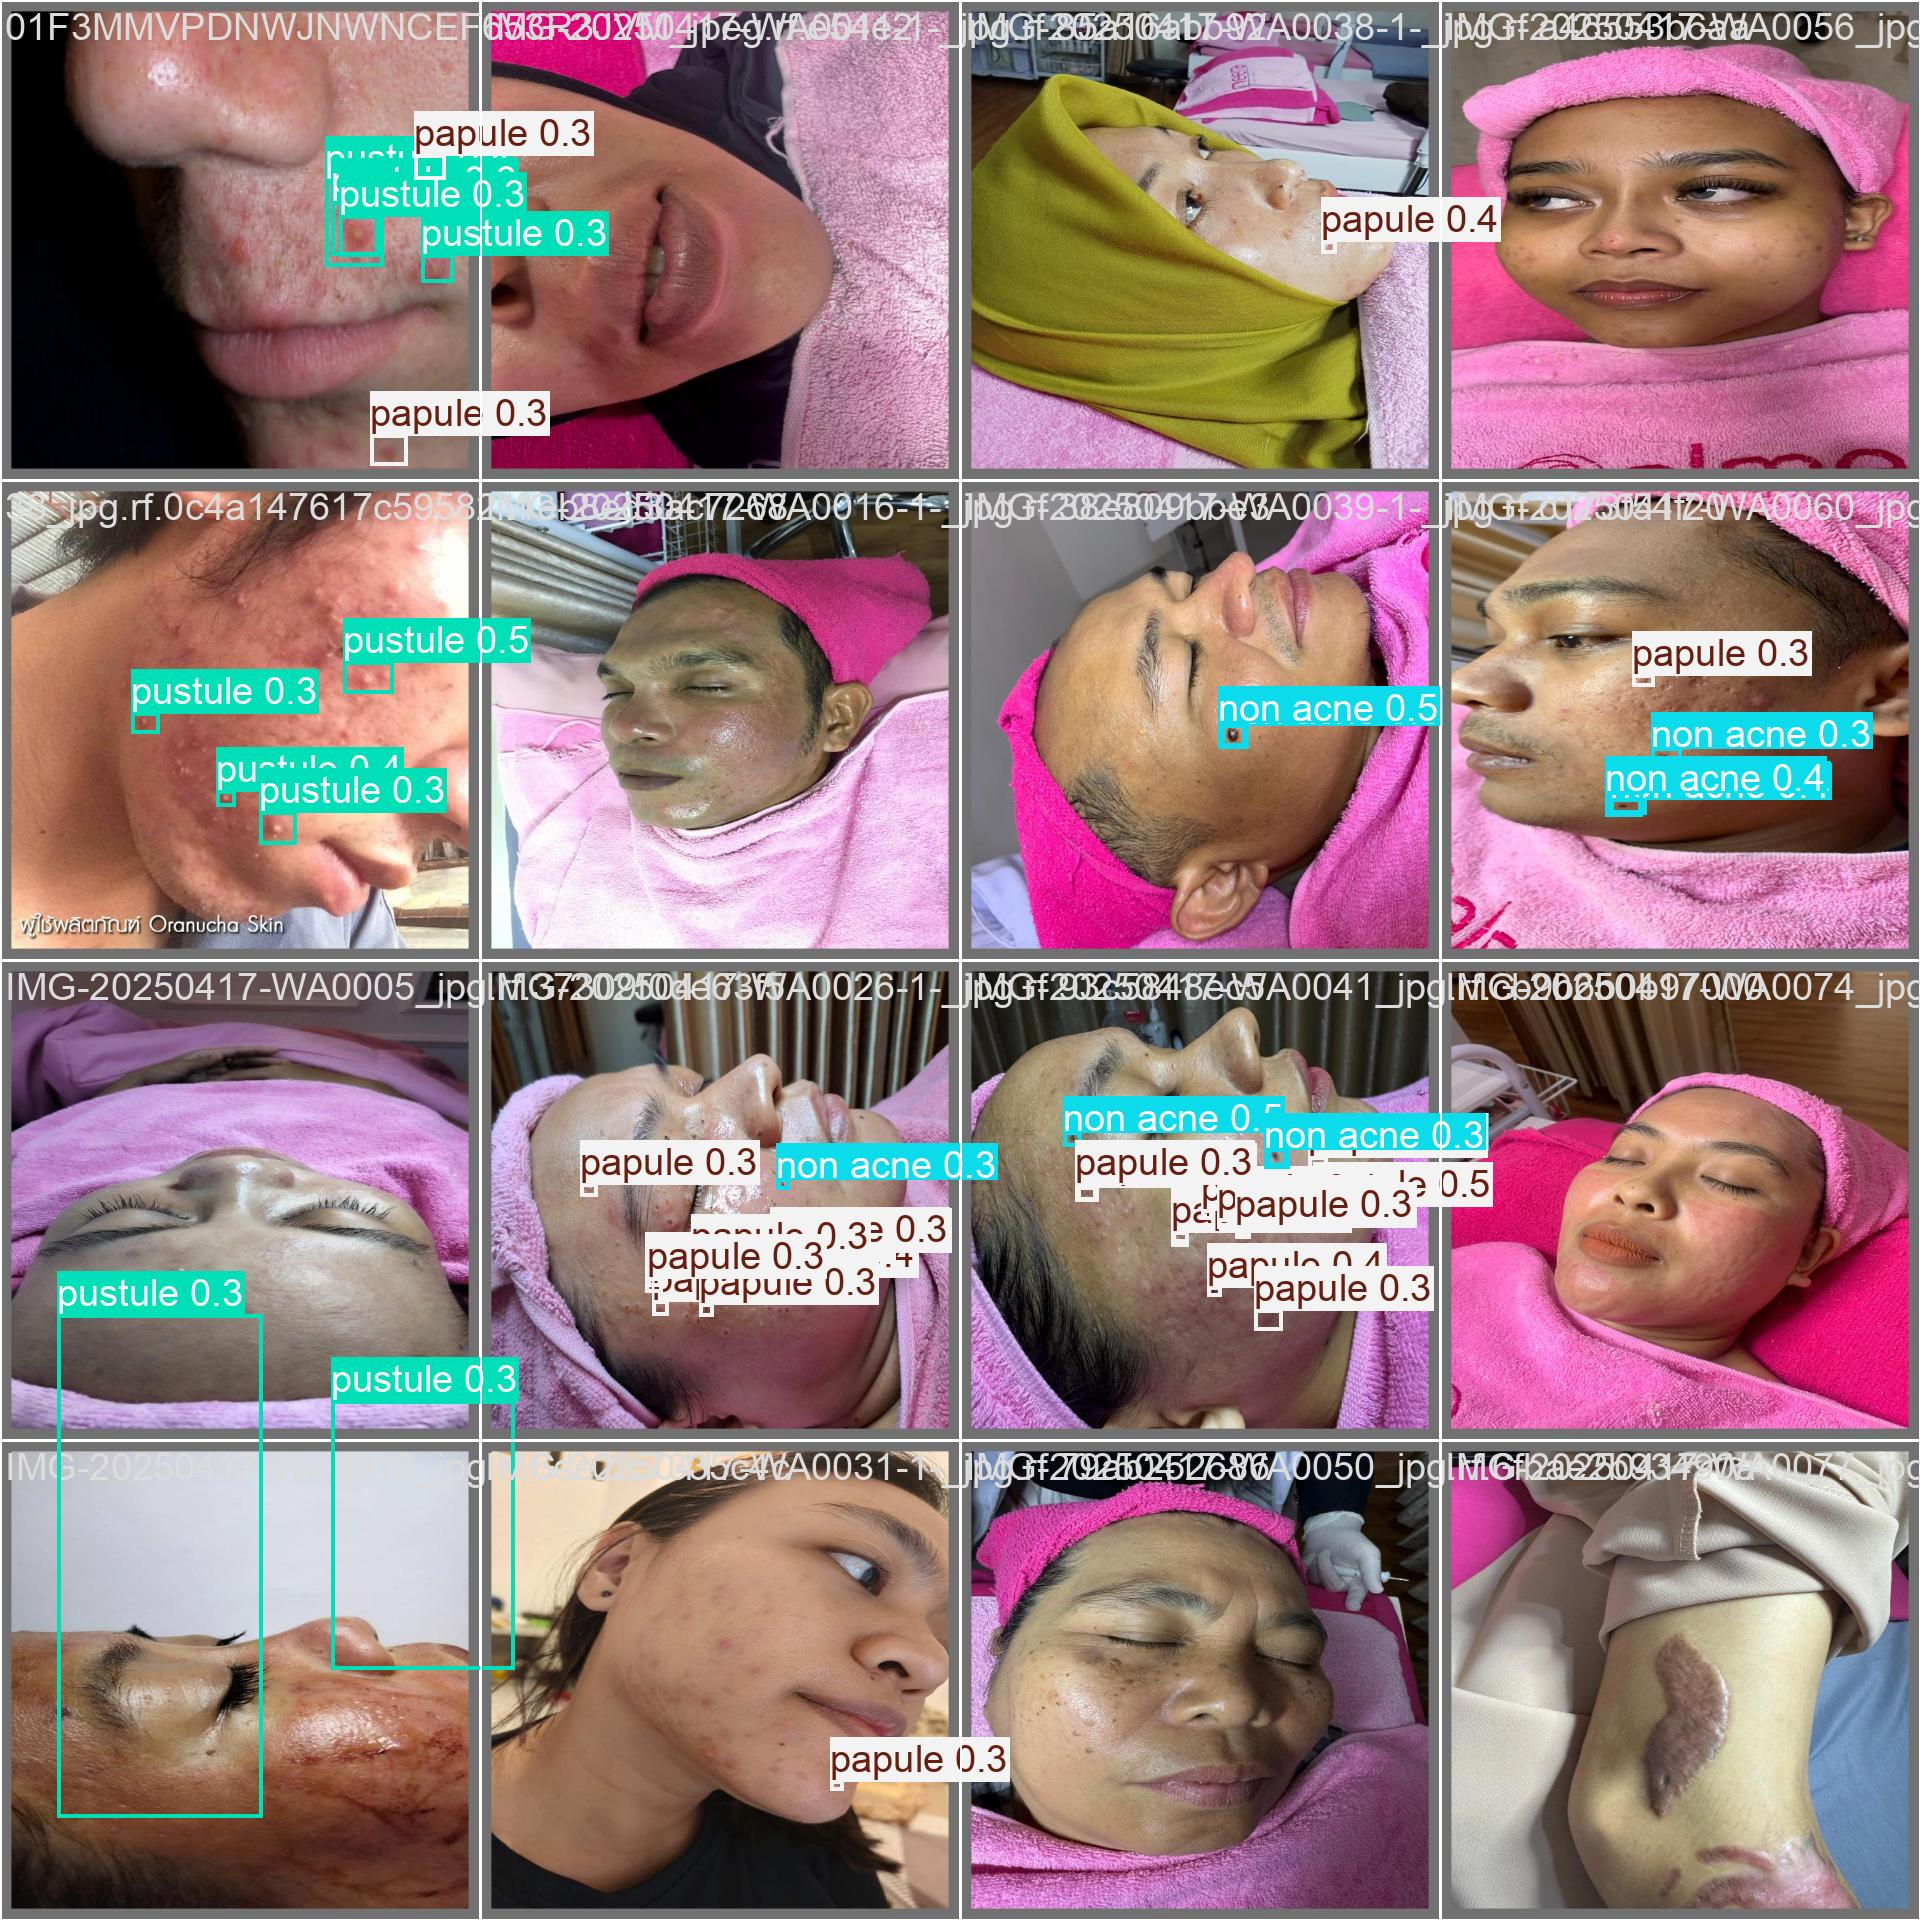

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [11]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1507.3±618.1 MB/s, size: 47.0 KB)
val: Scanning /content/datasets/Acne-2/valid/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100% 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.79it/s]
                   all         26         96       0.33      0.237      0.227     0.0936
                nodule          4          5      0.496        0.4      0.456      0.225
              non acne         11         21      0.175     0.0952      0.125     0.0413
                papule         12         34     0.0655      0.176     0.0564     0.0133
               pustule         11         36      0.583      0.278      0.269     0.0941
Speed: 0.3ms preprocess, 17.7ms inference, 0.0ms loss,

## Inference with custom model

In [12]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/14 /content/datasets/Acne-2/test/images/01F3MMX2RXFSJV79X3QMF6XXW8_jpeg.rf.1d048b66e977522d563ca2e6d1d3e123.jpg: 640x640 (no detections), 20.5ms
image 2/14 /content/datasets/Acne-2/test/images/01F3MMY5FZF8N8BX849Y22JCQW_jpeg.rf.ba9b016db7fe145917cfaf267ebb7684.jpg: 640x640 3 pustules, 15.7ms
image 3/14 /content/datasets/Acne-2/test/images/01F3MMYACD6GHPPGMBJ8SE65WG_jpeg.rf.d71e9fa02d08af57bdfffa586d472205.jpg: 640x640 6 papules, 15.7ms
image 4/14 /content/datasets/Acne-2/test/images/28_jpg.rf.85891df920f1187110094b8fc9704bee.jpg: 640x640 (no detections), 15.7ms
image 5/14 /content/datasets/Acne-2/test/images/IMG-20250417-WA0021-1-_jpg.rf.4bf6540cbdb4fcb7922f82ba89498a9c.jpg: 640x640 (no detections), 15.6ms
image 6/14 /content/datasets/Acne-2/test/images/IMG-20250417-WA0025-1-_jpg.rf.7f7e707897b1602c0d58a405faadff

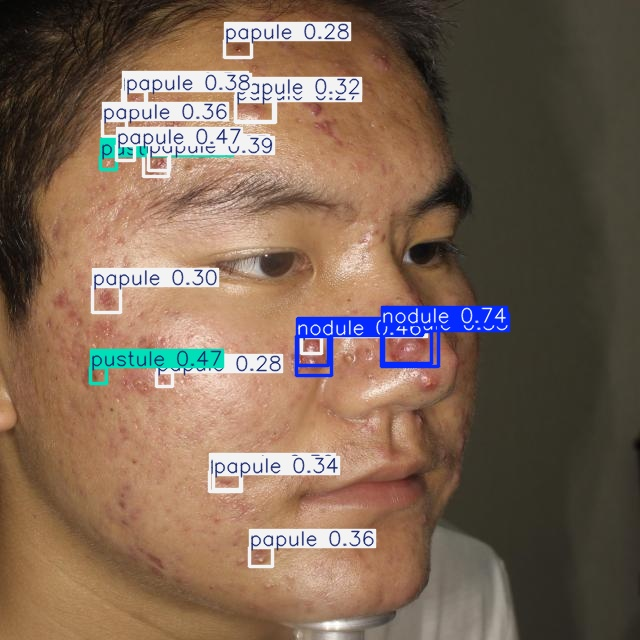

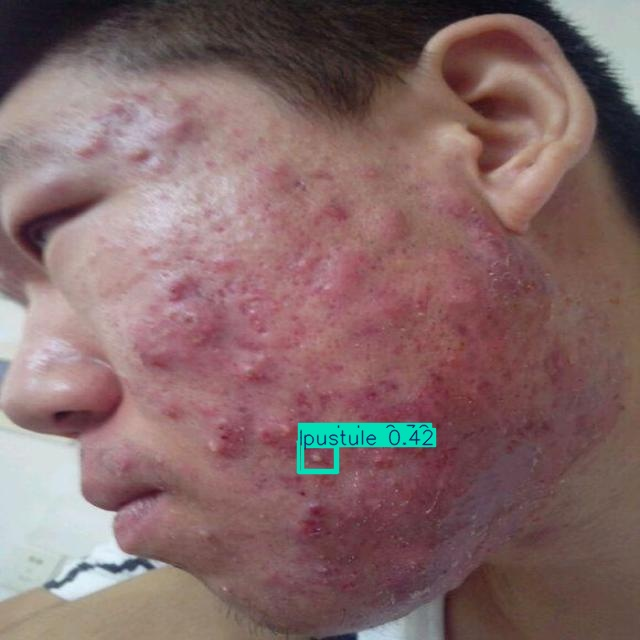

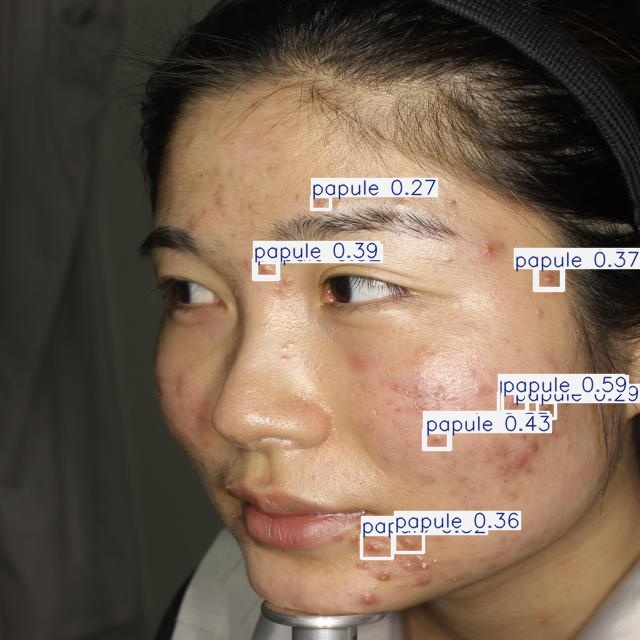

In [13]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")